In [ ]:
# !pip uninstall -y torch torchvision
# !pip install torch torchvision

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.optim as optim
import re
from collections import defaultdict

  # A. Art

In [5]:
# ! wget https://github.com/TemaBlag/Yandex_Training/tree/main/ml_training_3/hw6/best_pictures.tar.gz

In [9]:
import shutil

shutil.rmtree('/content/best_pictures')

In [13]:
# !mkdir best_pictures
# !tar -xzvf best_pictures.tar.gz -C best_pictures

In [5]:
# !pip install chardet

In [50]:
import chardet

folder_path = 'best_pictures'
txt_files = dict()
png_files = dict()

for filename in os.listdir(folder_path):
    full_path = os.path.join(folder_path, filename)
    if filename.endswith('.csv'):
        df_algos = pd.read_csv(full_path, header=None)
    elif filename.endswith('.txt'):
        with open(full_path, 'rb') as f:
            raw_data = f.read()
            result = chardet.detect(raw_data)
            encoding = result['encoding']
        with open(full_path, 'r', encoding=encoding) as f:
            content = f.read()
            txt_files[filename[:-4]] = content
    elif filename.endswith('.png'):
        image = Image.open(full_path)
        png_files[filename[:-4]] = image


In [51]:
len(txt_files.keys()), len(png_files.keys())

(1001, 1000)

In [52]:
set(txt_files.keys()) - set(png_files.keys())

{'._1'}

In [53]:
del txt_files['._1']

In [54]:
set(txt_files.keys()) - set(png_files.keys())

set()

In [55]:
png_files = {int(k) - 1: v for k, v in png_files.items()}
txt_files = {int(k) - 1: v for k, v in txt_files.items()}

In [56]:
df_algos.head()

,0,1,2,3,4,5,6,7,8
0,-1.0000,-0.5000,0.0000,-0.5000,0.5000,0.5000,0.0000,0.5000,1.0000
1,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625


In [154]:
conv1 = np.array(df_algos.loc[0].values)
conv2 = np.array(df_algos.loc[1].values)

In [58]:
def print_conv(conv):
    for i in range(0, len(conv), 3):
        print(" ".join(f"{x:2}" for x in conv[i:i+3]))

print('Conv1')
print_conv(conv1)
print('Conv2')
print_conv(conv2)

Conv1
-1.0 -0.5 0.0
-0.5 0.5 0.5
0.0 0.5 1.0
Conv2
0.0625 0.0625 0.0625
0.0625 0.0625 0.0625
0.0625 0.0625 0.0625


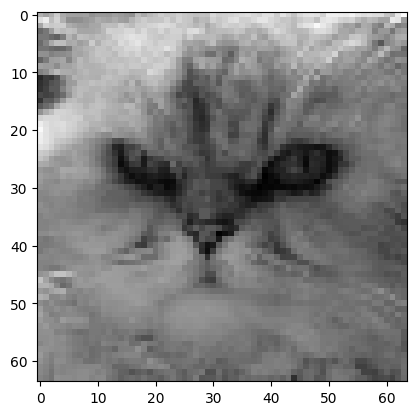

In [59]:
plt.imshow(png_files[0], cmap='gray')
plt.show()

In [155]:
import re
import torch

def replace_non_printable(text, replacement=0):
    texts = text.split()
    result = []
    for txt in texts:
        try:
            result.append(float(txt))
        except:
            result.append(replacement)
    return result

class MyDataset(Dataset):
    def __init__(self, img_transforms=None):
        super().__init__()
        self.images = png_files
        self.results = txt_files
        self.img_transforms = img_transforms

    def __getitem__(self, idx):
        image = self.images[idx]
        result = self.results[idx]
        while (len(result.split()) < 4096):
            idx += 1
            image = self.images[idx]
            result = self.results[idx]
        if self.img_transforms:
            image = self.img_transforms(image)
        clean_text = replace_non_printable(result)
        result = torch.tensor(clean_text, dtype=torch.float32).reshape(1, 64, 64)
        return image, result

    def __len__(self,):
        return len(self.images)

In [156]:
img_transforms = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x * 255.0)
])

dataset = MyDataset(img_transforms)
img, res = dataset[2]
print(img.shape, res.shape)

torch.Size([1, 64, 64]) torch.Size([1, 64, 64])


In [157]:
img[:, 0:3, 0:3]

tensor([[[195., 178., 163.],
         [190., 169., 182.],
         [193., 174., 187.]]])

In [158]:
import torch.nn.functional as F

class Convolution(nn.Module):
    def __init__(self, k, weights, padding=1):
        super().__init__()
        self.k = k
        self.padding = padding
        # weights - tensor with shape: (1, 1, k, k)
        self.weight = nn.Parameter(weights.unsqueeze(0).unsqueeze(0))  # shape: (1, 1, k, k)

    def forward(self, x):
        # x: (B, 1, H, W)
        return F.conv2d(x, self.weight, padding=self.padding)

In [159]:
class ConvNet(nn.Module):
    def __init__(self, weights1, weights2, weights3):
        super().__init__()
        self.conv1 = Convolution(3, weights=weights1)
        self.conv2 = Convolution(3, weights=weights2)
        self.conv3 = Convolution(3, weights=weights3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

In [160]:
conv1 = torch.tensor(conv1.reshape(3, 3), dtype=torch.float32, requires_grad=False)
conv2 = torch.tensor(conv2.reshape(3, 3), dtype=torch.float32, requires_grad=False)
conv3 = torch.randn(3, 3, dtype=torch.float32) * 0.1

In [123]:
conv1

tensor([[-1.0000, -0.5000,  0.0000],
        [-0.5000,  0.5000,  0.5000],
        [ 0.0000,  0.5000,  1.0000]])

In [124]:
conv3

tensor([[-0.0790, -0.0906, -0.0261],
        [-0.0547,  0.2117, -0.1712],
        [ 0.0165,  0.1582,  0.0448]])

In [68]:
model = ConvNet(conv1, conv2, conv3)

In [125]:
rec_img = model(img)
rec_img.shape

torch.Size([1, 64, 64])

In [161]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [129]:
torch.manual_seed(42)
models = [ConvNet(conv1.clone(), conv2.clone(), conv3.clone()),
          ConvNet(conv1.clone(), conv3.clone(), conv2.clone()),
          ConvNet(conv2.clone(), conv1.clone(), conv3.clone()),
          ConvNet(conv2.clone(), conv3.clone(), conv1.clone()),
          ConvNet(conv3.clone(), conv1.clone(), conv2.clone()),
          ConvNet(conv3.clone(), conv2.clone(), conv1.clone())]
epochs = 5
optimizers = [optim.Adam(models[0].conv3.parameters(), lr=0.1),
              optim.Adam(models[1].conv2.parameters(), lr=0.1),
              optim.Adam(models[2].conv3.parameters(), lr=0.1),
              optim.Adam(models[3].conv2.parameters(), lr=0.1),
              optim.Adam(models[4].conv1.parameters(), lr=0.1),
              optim.Adam(models[5].conv1.parameters(), lr=0.1)]
criterion = nn.MSELoss()
losses = defaultdict(list)

for i, (model, optimizer) in enumerate(zip(models, optimizers)):
    for epoch in range(epochs):
        epoch_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        losses[i].append(epoch_loss/len(dataloader))


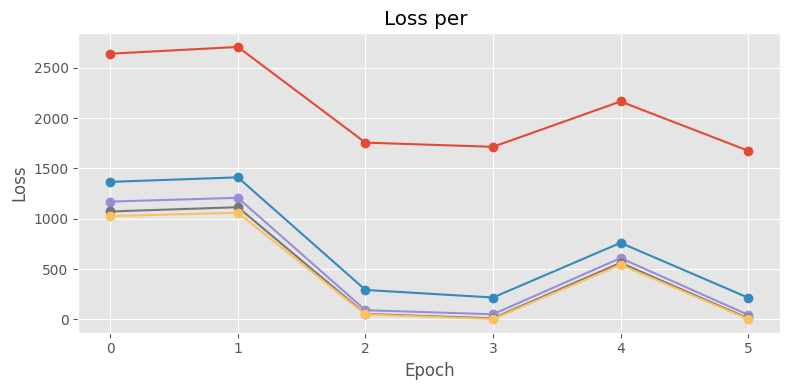

In [130]:
epochs = list(losses.keys())
values = list(losses.values())

plt.figure(figsize=(8, 4))
plt.plot(epochs, values, marker='o', linestyle='-')

plt.title('Loss per ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

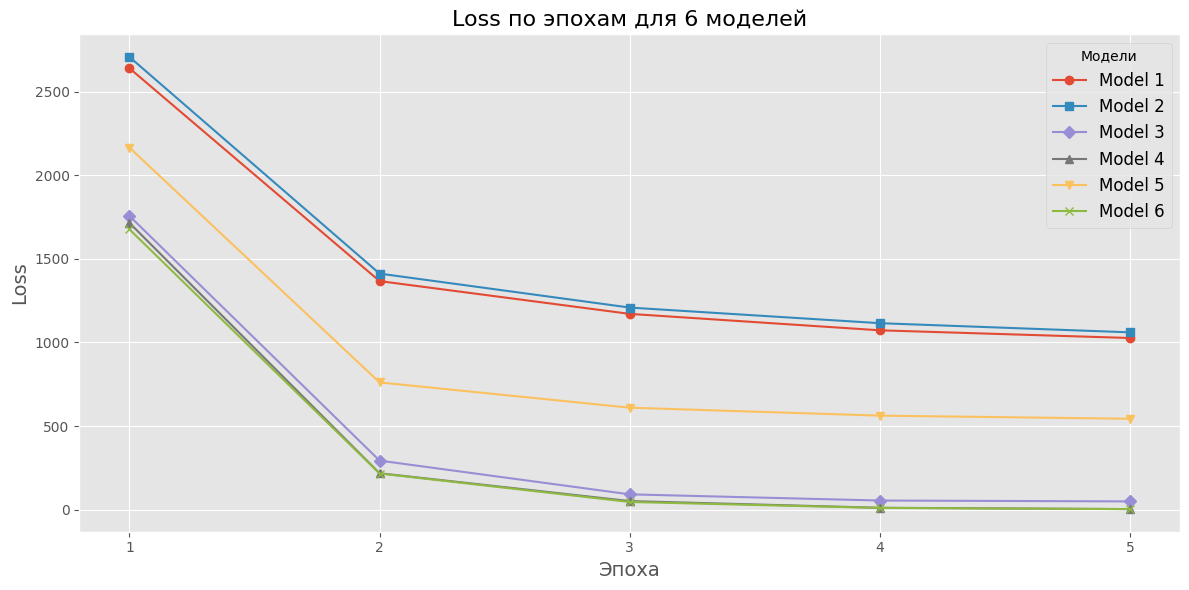

In [131]:
import matplotlib.pyplot as plt

model1_loss = losses[0]
model2_loss = losses[1]
model3_loss = losses[2]
model4_loss = losses[3]
model5_loss = losses[4]
model6_loss = losses[5]

epochs = list(range(1, 6))

plt.figure(figsize=(12, 6))
plt.style.use('ggplot')

plt.plot(epochs, model1_loss, label='Model 1', marker='o')
plt.plot(epochs, model2_loss, label='Model 2', marker='s')
plt.plot(epochs, model3_loss, label='Model 3', marker='D')
plt.plot(epochs, model4_loss, label='Model 4', marker='^')
plt.plot(epochs, model5_loss, label='Model 5', marker='v')
plt.plot(epochs, model6_loss, label='Model 6', marker='x')

plt.title("Loss по эпохам для 6 моделей", fontsize=16)
plt.xlabel("Эпоха", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(epochs)
plt.legend(title="Модели", fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()


In [133]:
for i in [2, 3, 5]:
    print(i, losses[i][4])

2 49.77292442321777
3 3.8441567942500114
5 3.666923888027668


In [137]:
torch.manual_seed(42)
models = [ConvNet(conv2.clone(), conv3.clone(), conv1.clone()),
          ConvNet(conv3.clone(), conv2.clone(), conv1.clone())]
epochs = 100
optimizers = [optim.Adam(models[0].conv2.parameters(), lr=0.1),
              optim.Adam(models[1].conv1.parameters(), lr=0.1)]
criterion = nn.MSELoss()
losses_3_5 = defaultdict(list)

for i, (model, optimizer) in enumerate(zip(models, optimizers)):
    for epoch in range(epochs):
        epoch_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        print(f"Epoch: {epoch}, loss: {epoch_loss/len(dataloader)}")
        losses_3_5[i].append(epoch_loss/len(dataloader))

Epoch: 0, loss: 1663.8704085350037
Epoch: 1, loss: 210.33751595020294
Epoch: 2, loss: 49.7699099779129
Epoch: 3, loss: 11.980654045939445
Epoch: 4, loss: 4.034760445356369
Epoch: 5, loss: 1.8169387131929398
Epoch: 6, loss: 1.0010144039988518
Epoch: 7, loss: 0.6426820233464241
Epoch: 8, loss: 0.42721739038825035
Epoch: 9, loss: 0.29152406845241785
Epoch: 10, loss: 0.20445635449141264
Epoch: 11, loss: 0.1487697698175907
Epoch: 12, loss: 0.11415738146752119
Epoch: 13, loss: 0.09146204218268394
Epoch: 14, loss: 0.07717443024739623
Epoch: 15, loss: 0.06785839586518705
Epoch: 16, loss: 0.061467902502045035
Epoch: 17, loss: 0.05735232005827129
Epoch: 18, loss: 0.05432353727519512
Epoch: 19, loss: 0.052046664990484715
Epoch: 20, loss: 0.050233453745022416
Epoch: 21, loss: 0.04845001851208508
Epoch: 22, loss: 0.04701306880451739
Epoch: 23, loss: 0.045472521567717195
Epoch: 24, loss: 0.04422830976545811
Epoch: 25, loss: 0.042837914545089006
Epoch: 26, loss: 0.04166481108404696
Epoch: 27, loss: 0

In [138]:
models[0].conv2.weight

Parameter containing:
tensor([[[[0.1394, 0.2209, 0.1408],
          [0.2289, 0.5485, 0.2209],
          [0.1326, 0.2291, 0.1392]]]], requires_grad=True)

In [139]:
models[1].conv1.weight

Parameter containing:
tensor([[[[0.1397, 0.2197, 0.1416],
          [0.2293, 0.5492, 0.2198],
          [0.1318, 0.2295, 0.1394]]]], requires_grad=True)

In [149]:
df = pd.DataFrame([models[0].conv1.weight.detach().numpy().squeeze(0).squeeze(0).reshape(9),
                   models[0].conv2.weight.detach().numpy().squeeze(0).squeeze(0).reshape(9),
                   models[0].conv3.weight.detach().numpy().squeeze(0).squeeze(0).reshape(9)])

In [150]:
df

,0,1,2,3,4,5,6,7,8
0,0.062500,0.06250,0.062500,0.06250,0.062500,0.062500,0.062500,0.06250,0.062500
1,0.139371,0.22086,0.140769,0.22885,0.548483,0.220919,0.132572,0.22907,0.139193
2,-1.000000,-0.50000,0.000000,-0.50000,0.500000,0.500000,0.000000,0.50000,1.000000


In [152]:
df.to_csv("reconstructed_algos.csv", header=False, index=False)

In [144]:
df = pd.DataFrame([models[1].conv1.weight.detach().numpy().squeeze(0).squeeze(0).reshape(9),
                   models[1].conv2.weight.detach().numpy().squeeze(0).squeeze(0).reshape(9),
                   models[1].conv3.weight.detach().numpy().squeeze(0).squeeze(0).reshape(9)])

In [111]:
df.loc[0] = [0.15, 0.2, 0.15, 0.2, 0.6, 0.2, 0.15, 0.2, 0.15]

In [112]:
df

,0,1,2,3,4,5,6,7,8
0,0.1500,0.2000,0.1500,0.2000,0.6000,0.2000,0.1500,0.2000,0.1500
1,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625
2,-1.0000,-0.5000,0.0000,-0.5000,0.5000,0.5000,0.0000,0.5000,1.0000


In [113]:
df.to_csv("reconstructed_algos.csv", header=False, index=False)

In [163]:
torch.manual_seed(42)
models = [ConvNet(conv2.clone(), conv3.clone(), conv1.clone())]
epochs = 400
optimizers = [optim.Adam(models[0].conv2.parameters(), lr=0.1)]
criterion = nn.MSELoss()
losses_3_5 = defaultdict(list)

for i, (model, optimizer) in enumerate(zip(models, optimizers)):
    for epoch in range(epochs):
        epoch_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        print(f"Epoch: {epoch}, loss: {epoch_loss/len(dataloader)}")
        losses_3_5[i].append(epoch_loss/len(dataloader))

Epoch: 0, loss: 1123.5216933488846
Epoch: 1, loss: 152.90231728553772
Epoch: 2, loss: 37.102502793073654
Epoch: 3, loss: 10.301355674862862
Epoch: 4, loss: 2.9711603298783302
Epoch: 5, loss: 1.2281791791319847
Epoch: 6, loss: 0.587274307385087
Epoch: 7, loss: 0.3025332326069474
Epoch: 8, loss: 0.17828820645809174
Epoch: 9, loss: 0.1238693525083363
Epoch: 10, loss: 0.0986113054677844
Epoch: 11, loss: 0.08562050852924585
Epoch: 12, loss: 0.07809647405520082
Epoch: 13, loss: 0.07196855754591525
Epoch: 14, loss: 0.06728749140165746
Epoch: 15, loss: 0.0628144764341414
Epoch: 16, loss: 0.058468280360102654
Epoch: 17, loss: 0.05472176801413298
Epoch: 18, loss: 0.051071491092443466
Epoch: 19, loss: 0.04764462518505752
Epoch: 20, loss: 0.04443372250534594
Epoch: 21, loss: 0.04115143558010459
Epoch: 22, loss: 0.03825323423370719
Epoch: 23, loss: 0.03536397323478013
Epoch: 24, loss: 0.0328170188004151
Epoch: 25, loss: 0.030331283225677907
Epoch: 26, loss: 0.02808209357317537
Epoch: 27, loss: 0.02

KeyboardInterrupt: 

In [164]:
df = pd.DataFrame([models[0].conv1.weight.detach().numpy().squeeze(0).squeeze(0).reshape(9),
                   models[0].conv2.weight.detach().numpy().squeeze(0).squeeze(0).reshape(9),
                   models[0].conv3.weight.detach().numpy().squeeze(0).squeeze(0).reshape(9)])

In [165]:
df

,0,1,2,3,4,5,6,7,8
0,0.062500,0.062500,0.062500,0.062500,0.062500,0.06250,0.062500,0.062500,0.06250
1,0.124047,0.251655,0.124219,0.251656,0.496788,0.25166,0.124228,0.251652,0.12405
2,-1.000000,-0.500000,0.000000,-0.500000,0.500000,0.50000,0.000000,0.500000,1.00000


In [166]:
df.to_csv("reconstructed_algos.csv", header=False, index=False)

# B. Operation: EchoTrace fixed

In [5]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

In [6]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [7]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [172]:
# !mkdir dataset

In [8]:
import zipfile
import os

zip_path = "/content/dataset.zip"
extract_path = "/content/dataset"

# Создание папки, если нужно
os.makedirs(extract_path, exist_ok=True)

# Распаковка архива
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = '/content/dataset/dataset'
images = dict()

for filename in tqdm(os.listdir(folder_path)):
    full_path = os.path.join(folder_path, filename)
    if filename.endswith('.png'):
        image = Image.open(full_path)
        with torch.no_grad():
            image_input = preprocess(image).unsqueeze(0)
            image_input = image_input.to(device)
            image_features = model.encode_image(image_input).float()
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            images[filename] = image_features.squeeze(0)

  0%|          | 0/9605 [00:00<?, ?it/s]

In [11]:
len(images.keys())

9605

In [15]:
import torch
from tqdm import tqdm

keys = list(images.keys())
embs = torch.stack([images[k] for k in keys], dim=0)  # (N, D)

# Нормализуем, чтобы каждая строка имела L2-норму 1
embs = embs / (embs.norm(p=2, dim=1, keepdim=True).clamp(min=1e-8))

In [16]:
S = embs @ embs.T  # (N, N)

# Чтобы не учитывать саму диагональ (сравнение с самим собой), зануляем её
S.fill_diagonal_(-1.0)

# Для каждой строки берём top-6 индексов
# topk возвращает значения и индексы; нам нужны индексы
values, indices = torch.topk(S, k=6, dim=1, largest=True)

# Собираем словарь ответов
answers_fast = {
    keys[i]: [keys[j] for j in indices[i].tolist()]
    for i in range(len(keys))
}

In [17]:
def topk_cosine(embs, k=6, block_size=1000):
    N, D = embs.shape
    embs = embs / embs.norm(p=2, dim=1, keepdim=True).clamp(min=1e-8)
    topk_indices = [None] * N
    for i in range(0, N, block_size):
        j = min(i + block_size, N)
        block = embs[i:j]                # (B, D)
        sims = block @ embs.T            # (B, N)
        sims[:, i:j].fill_diagonal_(-1)  # исключаем самих себя
        _, idx = torch.topk(sims, k=k, dim=1, largest=True)
        for bi, row in enumerate(idx):
            topk_indices[i + bi] = row.tolist()
    return topk_indices

topk_idx = topk_cosine(embs, k=6)
answers_fast = {
    keys[i]: [keys[j] for j in topk_idx[i]]
    for i in range(len(keys))
}

In [18]:
import pandas as pd

rows = []
for filename, neighbors in answers_fast.items():
    ranking_str = " ".join(neighbors)
    rows.append({"filename": filename, "ranking": ranking_str})

df = pd.DataFrame(rows, columns=["filename", "ranking"])
df.sort_values("filename", inplace=True)
df.to_csv("submission.csv", index=False)